## Housing Value and the Unemployment in the United States
#### Abstract:
Upon first reflection, it seems that there would some correlation between unemployment and housing value. If unemployment rises, less people may be able to afford the home they live in, leading to the person in question selling their home. With more houses on the market, housing value may drop. However, even if the one who is unemployed does not sell their house, they may not be able to afford up-keep on the house. This too would cause a drop in housing value.

The Bureau of Labor Statistics (BLS) and Federal Housing Finance Agency (FHFA) publish datasets that allow this theory to be tested. Nationally, it is found that there is a weak negative correlation between the unemployment rate and housing value of -0.28. When correlations are grouped by metro area, there are some signifcant outliers where the correlation is much stronger or much weaker. A time-series analysis is performed on a four select metro areas, which include the two minimal and maximal outliers, and two middling metro areas closer to the national average. Local correlation and housing value are plotted to visualize their relationship over time. The graphs suggest that factors other than unemployment often drive housing prices.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from src.cleaning import DataCleaner    # imports my cleaning class from cleaning.py

In [2]:
# initialize data cleaner class, insert file paths to raw data sets.
data_cleaner = DataCleaner('data/raw/hpi_po_metro.csv', 'data/raw/ssamatab1.csv')

# clean unemployment data set using the DataCleaner class.
clean_unemployment_data = data_cleaner.clean_unemployment_data

# clean the housing dataset using the DataCleaner class.
clean_housing_data = data_cleaner.clean_housing_data

In [3]:
# group clean_housing_data and clean_unemployment_data by year to allow the data to be joined.
grouped_housing_data = clean_housing_data.drop(columns=['Quarter','Not_Seasonally_Adjusted_Index'] ).groupby(['CBSA', 'Metro_Name', 'Year']).agg('mean').reset_index()
grouped_unemployment_data = clean_unemployment_data.drop(columns="Month").groupby(['LAUS_Code','State_FIPS_Code','FIPS_Code','Area','Year']).agg('mean').round(2).reset_index()

# move the decimal on the Unemployment_Rate column.
grouped_unemployment_data["Unemployment_Rate"] = grouped_unemployment_data["Unemployment_Rate"] / 10

In [4]:
# make SQL database with tables "Unemployment" and "Housing_value."
with sqlite3.connect("database.db") as conn:
    grouped_unemployment_data.to_sql(
        "Unemployment", 
        conn, 
        if_exists='replace', 
        index=False
        )
    grouped_housing_data.to_sql(
        "Housing_Value", 
        conn, 
        if_exists='replace', 
        index=False
        )

In [5]:
# SQL query that joins the two tables Unemployment and Housing_value on the CBSA/FIPS code 
tables_unemployment_and_housing_value_joined = """

SELECT 
    Unemployment.LAUS_Code,
    Unemployment.Year,
    Unemployment.Area,
    Unemployment.Employment,
    Unemployment.Unemployment,
    Unemployment.Unemployment_Rate,
    Housing_Value.Metro_Name,
    Housing_Value.Seasonally_Adjusted_Index
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
;
    
"""
# saves the query as a dataframe.
tables_unemployment_and_housing_value_joined_result = pd.read_sql(tables_unemployment_and_housing_value_joined, conn)

In [6]:
# group the combined table by area, returning the metro name, unemployment rate, and seasonally adjusted index.
tables_unemployment_and_housing_value_joined_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"])[["Unemployment_Rate", "Seasonally_Adjusted_Index"]].mean().round(2).reset_index()

# find the correlation by area.
correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(lambda x: x["Unemployment_Rate"].corr(x["Seasonally_Adjusted_Index"]).round(2)).rename("Correlation").reset_index()

/tmp/ipykernel_11811/328213207.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(lambda x: x["Unemployment_Rate"].corr(x["Seasonally_Adjusted_Index"]).round(2)).rename("Correlation").reset_index()


In [7]:
# inserts two tables into database.db.
with sqlite3.connect("database.db") as conn:
    tables_unemployment_and_housing_value_joined_grouped_by_area.to_sql(
        name="Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area",
        con=conn, 
        if_exists="replace"
        )
    correlations_table_grouped_by_area.to_sql(
        name="Correlations_by_Metro_Area",
        con=conn,
        if_exists="replace"
        )

In [8]:
# SQL query to merge the tables "Unemployment_Rate_and_SAI_by_Metro_Area and Correlations_by_Metro_Area."
unemployment_rate_and_seasonally_adusted_index_joined_to_correlations = """

SELECT
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Unemployment_Rate,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Seasonally_Adjusted_Index,
    Correlations_by_Metro_Area.Correlation
FROM Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area
INNER JOIN Correlations_by_Metro_Area
    ON Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name = Correlations_by_Metro_Area.Metro_Name
ORDER BY Correlations_by_Metro_Area.Correlation DESC
;

"""
# saves SQL query as a dataframe.
unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result = pd.read_sql(unemployment_rate_and_seasonally_adusted_index_joined_to_correlations, conn)

In [9]:
# SQL query that joins Unemployment and Housing_Value on the Metro_Name and filters by four specific metro areas.
four_metros_query = """

SELECT
    Unemployment.Year,
    Unemployment.Employment,
    Unemployment.Unemployment,
    ROUND(Unemployment.Unemployment_Rate, 2) AS Unemployment_Rate,
    Housing_Value.Metro_Name,
    ROUND(Housing_Value.Seasonally_Adjusted_Index, 2) AS Housing_Value_SAI
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
WHERE Housing_Value.Metro_Name 
    IN (
        "Fresno, CA", 
        "Des Moines-West Des Moines, IA",
        "Tulsa, OK",
        "Louisville/Jefferson County, KY-IN"
    )
;

"""

# saves the SQL to a pandas dataframe
four_metros_query_result = pd.read_sql(four_metros_query, conn)

## Weak National Correlation Between Unemployment and Housing Value (-0.28)
- Data ranges from 1990 - 2025 and covers a significant sampling of the United States.
- In certain datasets, the federal government classifies the United States geographically by a five-digit Core-Based Statistical Area (CBSA) or FIPS code. Of the 393 geographical areas provided by the BLS and the 100 by the FHFA, sixty-seven CBSAs are joined. This allows us to survey a significant subset of metro areas.

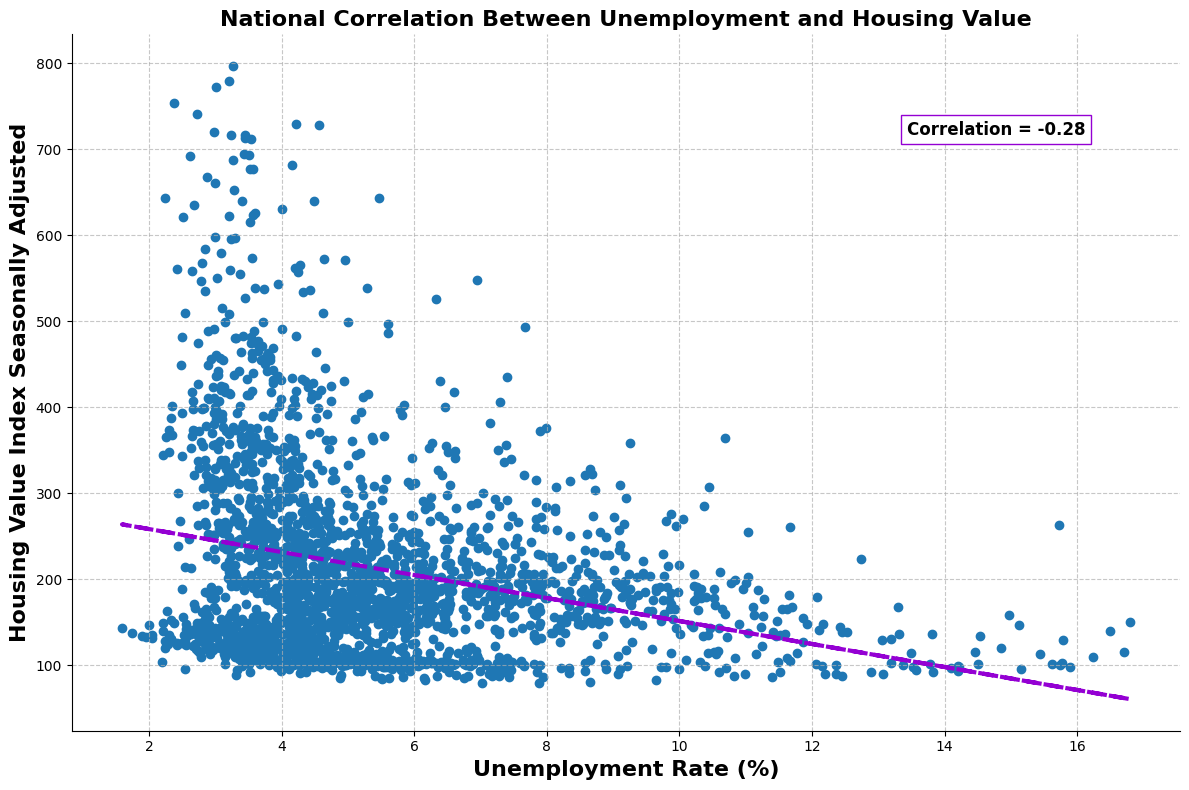

In [10]:
# scatter plot finds the national correlation between the housing value index and the unemployment rate.
x = tables_unemployment_and_housing_value_joined_result['Unemployment_Rate']
y = tables_unemployment_and_housing_value_joined_result['Seasonally_Adjusted_Index']

correlation = x.corr(y).round(2)
slope, intercept = np.polyfit(x, y, 1)      # np.polyfit calculates the slope and intercept for the y_fit
y_fit = (slope * x) + intercept             # y_fit used to plot the y axis for the correlation line

fig, ax = plt.subplots(figsize=(12,8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Unemployment Rate (%)", fontweight='bold', fontsize=16)
ax.set_ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold', fontsize=16)
ax.set_title("National Correlation Between Unemployment and Housing Value", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)    # places a grid for easier estimatiion of the x/y value of a particular plot point.
ax.plot(x, y_fit, color="darkviolet", linewidth=3, linestyle="--")  # plots the line of correlation.

# places a box in the upper righthand corner of the plot to show the national correlation value.
ax.text(
    x.max() * 0.80,
    y.max() * 0.90, 
    f'Correlation = {correlation}',
    fontweight="bold", 
    fontsize=12,
    bbox={'facecolor': 'white', 'edgecolor': 'darkviolet'}
    )

ax.scatter(x,y) # instantiate the scatter plot.
plt.tight_layout()
plt.show()

# Is Correlation Stronger in Certain Metro Areas?
- Correlation is calculated by metro area. When sorted, the bar chart shows a a few outliers where correlation is very strong. The majority are between -0.40 and -0.20, with another minority showing even weaker correlation.

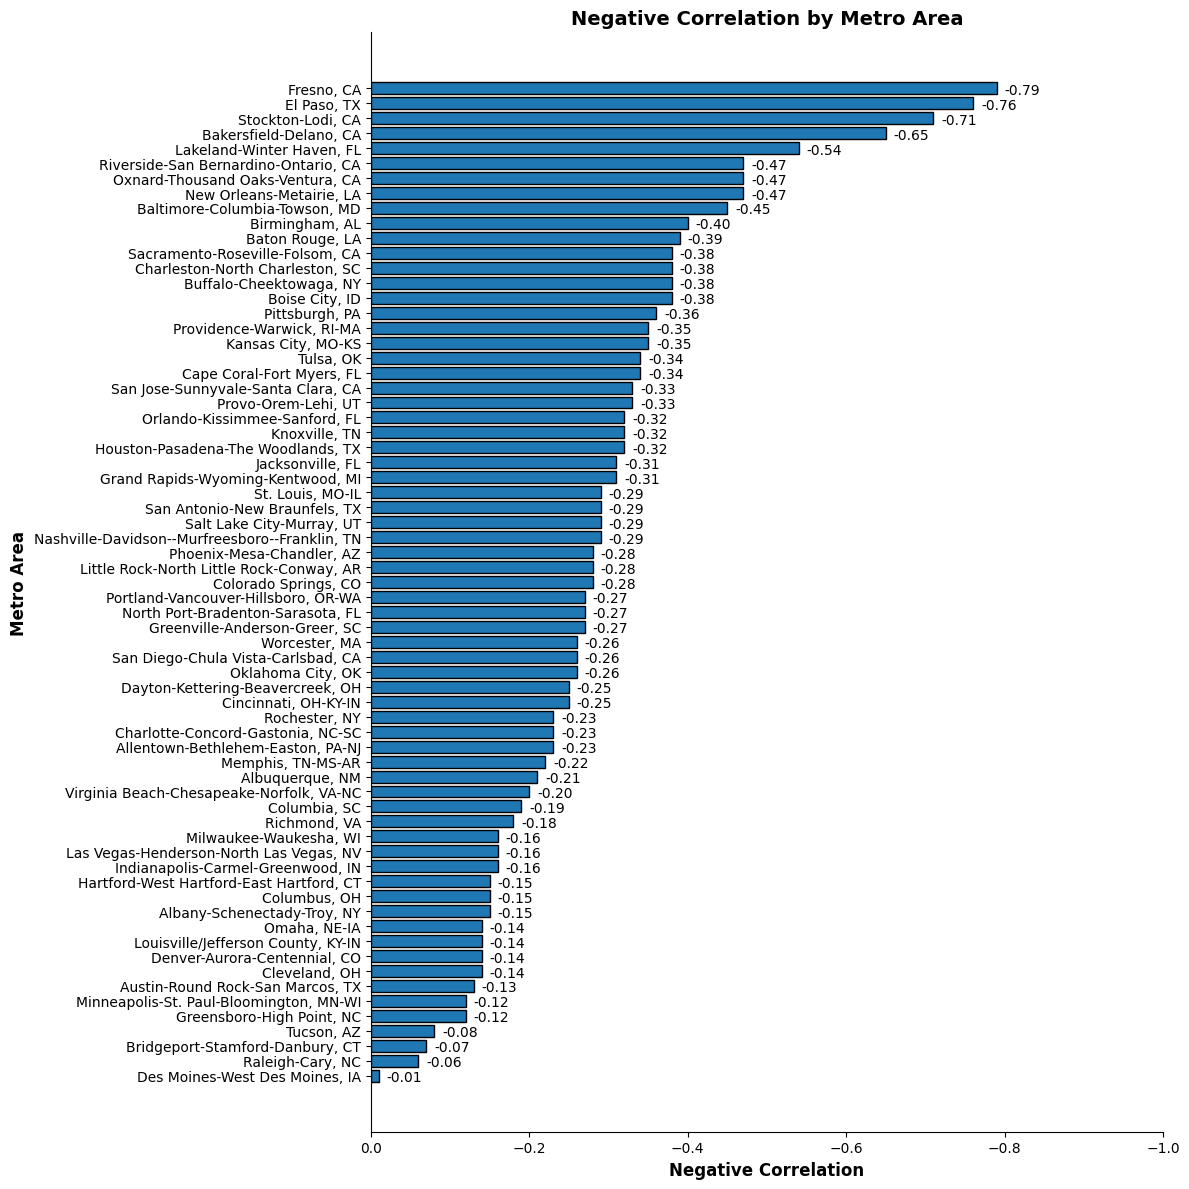

In [11]:
x = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Metro_Name"]
y = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Correlation"]

fig, ax = plt.subplots(figsize=(12,12))

# set the title, spine visibility, and axis labels
ax.set_title("Negative Correlation by Metro Area", fontweight="bold", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Negative Correlation", fontweight="bold", fontsize=12)
ax.set_ylabel("Metro Area", fontweight="bold", fontsize=12)
ax.set_xlim(0, -1)

# plot as a horizontal bar chart
bars = plt.barh(x,y, edgecolor="black")

# Used a for loop to get the correlation values and place them just to the right of the bar. 
for bar in bars:
    value = bar.get_width()
    ax.text(x=value - 0.01, y=(bar.get_y() + bar.get_height() - 0.50),s=f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Time Series Analysis of Four Metro Areas
- This time series analysis visualzes what was shown in the bar chart. The minimal (Des Moines, IA) and maximal (Fresno, CA) outliers are chosen as well as Louisville, KY, for personal reasons (this is my home), and Tulsa, OK, where the correlation is slighty stronger than normal. 
- Significant national events are seen within these cities. During the housing crisis of 2008, unemployment rose sharply in all four cities and housing value dipped, though almost imperceptibly in Louisville, and Tulsa. 
- During COVID in 2020, unemployment spiked significantly in all four cities, yet housing value rose. From common knowledge, we may speculate that housing value rose because of the increase in remote jobs which gave many people a newfound liberty to move. With more people moving, housing value rose with demand.

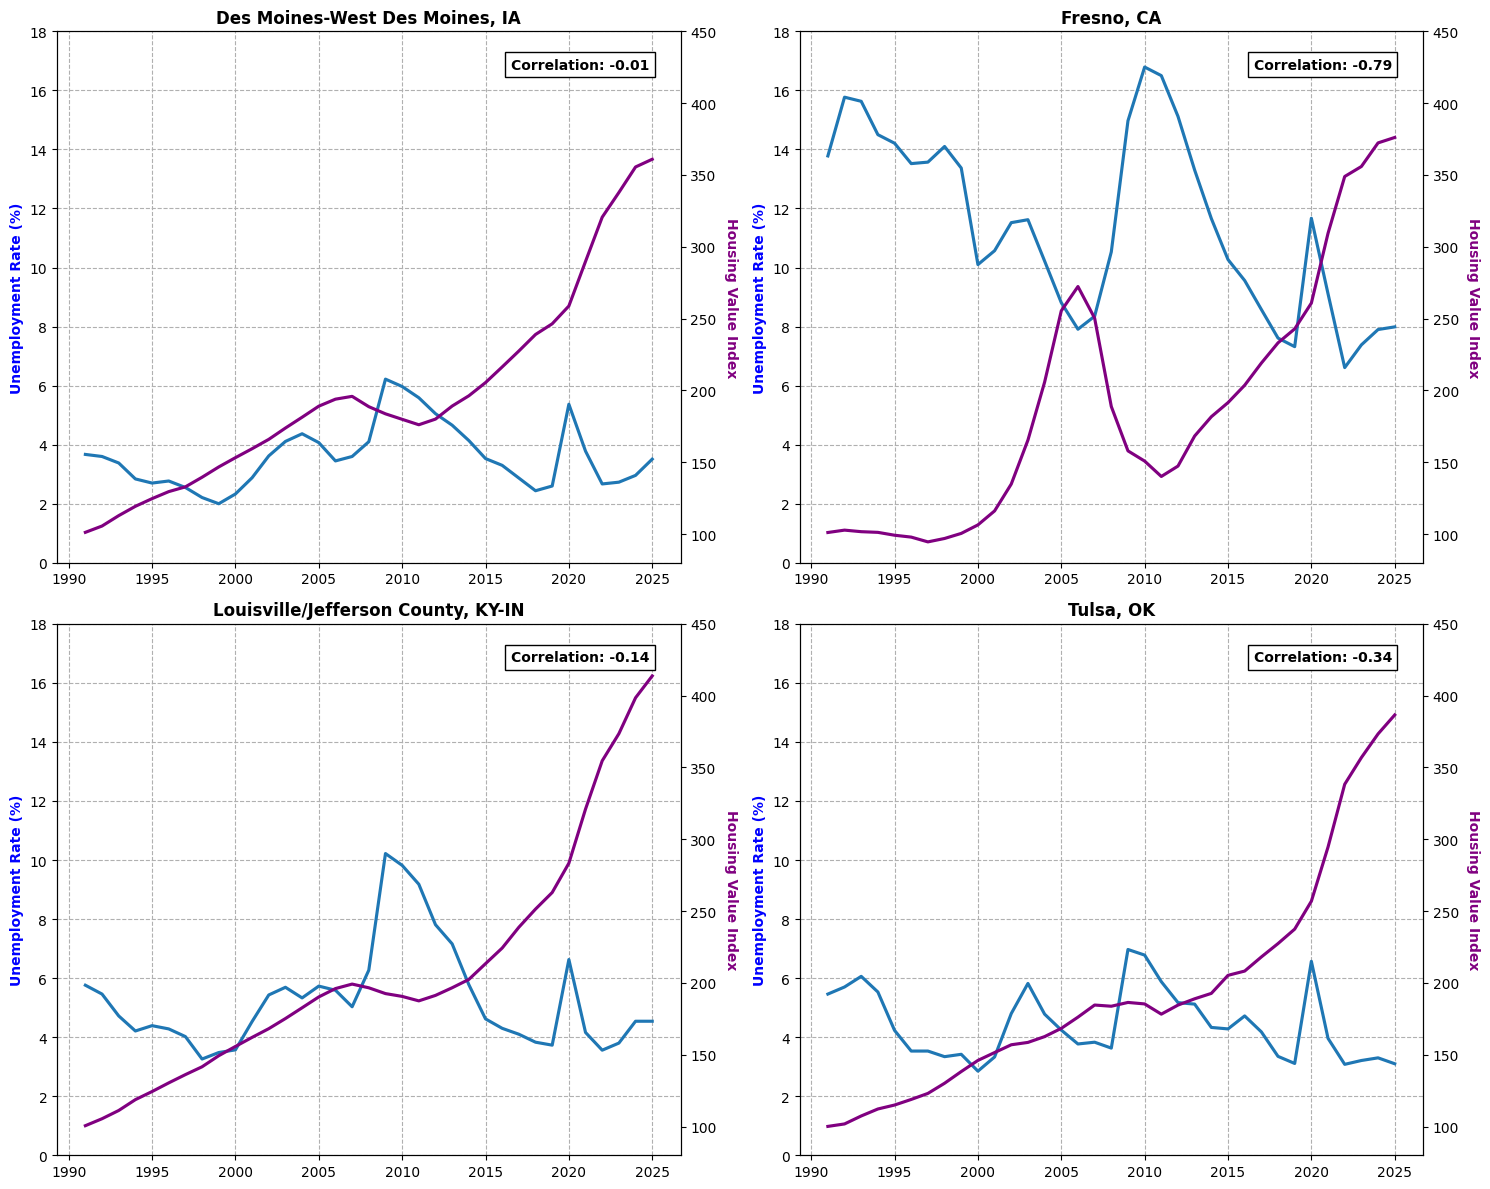

In [14]:
# create four subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

ax = ax.flatten()   # flatten to 1-D list for looping

metro_names = four_metros_query_result["Metro_Name"].unique()   # find the unique city names and save in a list

# for loop to plot each 
for metro, ax in zip(metro_names, ax):
    metro_data = four_metros_query_result[four_metros_query_result["Metro_Name"] == metro]
    
    correlation = metro_data["Unemployment_Rate"].corr(metro_data["Housing_Value_SAI"]).round(2)     # calculate the correlation for the title
    
    # plot the left axis, which is the unemployment rate.
    ax.plot(
        metro_data["Year"],
        metro_data["Unemployment_Rate"],
        linewidth=2.25
        )
   
    ax.set_ylabel("Unemployment Rate (%)", fontweight="bold", fontsize=10, color="blue")  # give the left axis a name.
    ax.set_title(f"{metro}", fontweight="bold")
    ax.set_ylim(0,18)
    ax.grid(True, linestyle='--')   # adds a grid to the background of the plots for easier placing of the line values.
    # ax.text adds a box in the upper right-hand corner of each plot with the global correlation of each metro area.
    ax.text(
        x=0.95,
        y=0.95,
        s=f"Correlation: {correlation}",
        fontweight="bold",
        fontsize=10,
        ha="right",
        va="top",
        bbox={'facecolor' : 'white'},
        transform=ax.transAxes      # transforms the coordinate system to be relative to the current subplot.
        ) 
    
    # plot the right axis, which is the housing value index. 
    ax2 = ax.twinx() # plots a second y axis on the righthand side of the plot, sharing an x axis.
    ax2.plot(
        metro_data["Year"],
        metro_data["Housing_Value_SAI"],
        color='purple',
        linewidth=2.25
        )
    ax2.set_ylabel("Housing Value Index", fontweight="bold", rotation=270, labelpad=15, fontsize=10, color="purple")
    ax2.set_ylim(80,450)
    
plt.tight_layout()    
plt.show()